In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='combinedDatasets'
print(fileloc_data)
#sys.path.append('/'.join(os.getcwd().split('/')[0:4])+'/nan_smote/')
from FigPlotting import clusterPlot
#############################################
df_main=pd.read_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit1_Only.tsv', sep='\t', decimal=',')
print(df_main.columns)
print(df_main['pid'].nunique(), df_main['intid'].nunique())
#df_main.head(3)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
Index(['intid', 'seq_num-edeq', 'EDEQscore', 'pid', 'p_startdate',
       'p_dischargedate', 'age', 'bsex', 'edu_level', 'edu_comp',
       'Highest_Edu', 'EDtype', 'icd9_code', 'icd9_lab', 'BMI', 'IND_anders',
       'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
       'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten',
       'andere_comorbiditeiten', 'duur_stoornis_in_jaren', 'interpretation',
       'leeftijd_invullen', 'p_dectool_invultijd', 'seq_num-dec',
       'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde', 'Split'],
      dtype='object')
298 300


In [2]:
df_dec_mhcsf_sq48=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Visit1.tsv', sep='\t', decimal=',')
print(df_dec_mhcsf_sq48['pid'].nunique(),df_dec_mhcsf_sq48['intid'].nunique())
pid_per_intid=df_dec_mhcsf_sq48['pid'].value_counts()
print('PIDs repeated in INTIDs: ', pid_per_intid[pid_per_intid.values>1])

294 296
PIDs repeated in INTIDs:  pid
461    2
530    2
Name: count, dtype: int64


In [3]:
print(df_dec_mhcsf_sq48.columns)
colsMain=['age','bsex','Highest_Edu','BMI', 'IND_anders', 'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
    'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar', 'IND_eerdere_spec_behandeling_zonder_effect', 
    'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI', 'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten',
    'andere_comorbiditeiten', 'duur_stoornis_in_jaren', 'interpretation', 'leeftijd_invullen','uitslag_waarde', 
    'verstoord_eetpatroon', 'volgorde', 'Split', 'EDEQscore','EDtype']
colsEDEQ=['eating', 'weight','bodyshape', 'lines']
colsMHSCF_SQ48=['age', 'bsex', 'BMI', 'Highest_Edu', 'Vijandigheid', 'Agorafobie', 'Angst', 'Cognitieve_Klachten','Depressie',
    'Somatische_Klachten', 'Sociale_Fobie', 'Vitaliteit_Optimisme', 'Werk_Studie', 'IND_anders','IND_as_I_II_comorbiditeiten',
    'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit','IND_duur_stoornis_2plus_jaar', 
    'IND_eerdere_spec_behandeling_zonder_effect','IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
    'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'andere_comorbiditeiten', 'duur_stoornis_in_jaren',
    'leeftijd_invullen', 'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde','EmotionWB', 'PsychWB', 
    'SocialWB', 'mhcsf_score','SQ48score', 'EDEQscore', 'Split', 'EDtype']

df_dec_mhcsf_sq48[['IND_anders', 'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit',
       'IND_duur_stoornis_2plus_jaar','IND_eerdere_spec_behandeling_zonder_effect', 'IND_ernstig_verstoord_eten', 
       'IND_extreem_laag_hoog_BMI','IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'age',
       'andere_comorbiditeiten','verstoord_eetpatroon', 'volgorde','EmotionWB', 'PsychWB']].head(4)

Index(['pid', 'intid', 'seq_num-sq48', 'Split', 'p_sq48_filled_date',
       'Vijandigheid', 'Agorafobie', 'Angst', 'Cognitieve_Klachten',
       'Depressie', 'Somatische_Klachten', 'Sociale_Fobie', 'SQ48score',
       'Vitaliteit_Optimisme', 'Werk_Studie', 'BMI', 'EDEQscore', 'EDtype',
       'Highest_Edu', 'IND_anders', 'IND_as_I_II_comorbiditeiten',
       'IND_borderline_comorbiditeit', 'IND_depressie_comorbiditeit',
       'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten', 'age',
       'andere_comorbiditeiten', 'bsex', 'duur_stoornis_in_jaren', 'edu_level',
       'icd9_lab', 'interpretation', 'leeftijd_invullen',
       'p_dectool_invultijd', 'p_dischargedate', 'p_startdate', 'seq_num-dec',
       'seq_num-edeq', 'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde',
       'EmotionWB', 'PsychWB', 'SocialWB', 'mhcsf_score'

,IND_anders,IND_as_I_II_comorbiditeiten,IND_borderline_comorbiditeit,IND_depressie_comorbiditeit,IND_duur_stoornis_2plus_jaar,IND_eerdere_spec_behandeling_zonder_effect,IND_ernstig_verstoord_eten,IND_extreem_laag_hoog_BMI,IND_ocd_comorbiditeit,aantal_eerdere_trajecten,age,andere_comorbiditeiten,verstoord_eetpatroon,volgorde,EmotionWB,PsychWB
0,1,1,0,0,1,1,0,0,0,8.0,47,vermoeden van persoonlijkheidsprobl.,NaN,1,3.3,2.5
1,1,1,0,0,0,0,1,1,0,NaN,19,NaN,NaN,1,2.7,2.7
2,1,1,1,0,1,1,1,0,0,1.0,50,"burnout, verslavingsgevoeligheid",Frequente eetbuien + braken.,1,3.0,2.0
3,0,0,0,0,0,1,1,1,0,1.0,21,NaN,"Sterk restrictief, afvallen ondanks eetlijst d...",1,3.7,3.2


### Correlation Matrix of the combined datasets

In [4]:
df_Questionnaires=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',')
df_edeq=pd.read_csv(fileloc_data+'maskedDAIsy_EDEQ_Score.tsv', sep='\t', decimal=',')
print(df_edeq.columns)
df_edeq['intid'] = df_edeq['intid'].astype(float)
df_edeq_reqd=df_edeq[['intid', 'seq_num-edeq','eating', 'weight','bodyshape', 'lines']].loc[df_edeq['seq_num-edeq']==1].copy()
df_Question_EDEQ=pd.merge(df_edeq_reqd, df_Questionnaires, on='intid', how='inner')
colsDectools=['uitslag_waarde', 'BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', 
    'IND_duur_stoornis_2plus_jaar', 'duur_stoornis_in_jaren', 'IND_as_I_II_comorbiditeiten',
    'IND_depressie_comorbiditeit', 'IND_borderline_comorbiditeit', 'IND_ocd_comorbiditeit', 'IND_anders',
    'IND_ernstig_verstoord_eten']
colsEDEQ=['eating', 'weight', 'bodyshape', 'lines']
#colsEDQOL=['Psychologisch', 'FysiekCognitief','Financieel', 'WerkSchool', 'EDQOLscore']
colsHonos=['Somscore', 'Beperkingen', 'Functioneren', 'Gedragsproblemen', 'Symptomalogie', 'SocialeProblemen']
colsLAV=['Negatieve_Waardering', 'Gebrek_Vertrouwdheid', 'Algemene_Ontevredenheid', 'LAV_Score']
colsSQ48=['Vijandigheid','Agorafobie','Angst','Depressie', 'Cognitieve_Klachten','Somatische_Klachten', 'Sociale_Fobie',
          'Vitaliteit_Optimisme', 'Werk_Studie', 'SQ48score']
colsMHCSF=['EmotionWB', 'SocialWB', 'PsychWB', 'mhcsf_score']

colNames=['Main-Age', 'Main-BSex','Main-EduLevel', 'Main-ED_Codes', 'EDEQ-score','EDEQ-eating', 'EDEQ-weight', 'EDEQ-bodyshape',
'EDEQ-lines', 'DT-uitslag_waarde','DT-BMI', 'DT-IND_prev_spec_int_wo_eff', 'DT-num_prev_routes', 'DT-IND_Disorder_Duration_2+Yrs',
'DT-Disorder_Duration_Yrs', 'DT-IND_I_II_CMD', 'DT-IND_depressie_CMD','DT-IND_BDL_CMD', 'DT-IND_OCD_CMD', 'DT-IND_others',
'DT-IND_VDisturbdEating', 'Honos-Somscore', 'Honos-Beperkingen','Honos-Functioneren', 'Honos-Gedragsproblemen', 
'Honos-Symptomalogie', 'Honos-SocialeProblemen','Lav-Neg_Waardering','Lav-Gebrek_Vertrouwdheid', 'Lav-Alg_Ontevredenheid', 
'Lav-Score', 'SQ48-Hostility','SQ48-Agorafobie','SQ48-Angst','SQ48-Depressie','SQ48-Cognitieve_Complain',
'SQ48-Somatische_Complain', 'SQ48-Sociale_Fobie','SQ48-Vitaliteit_Optimisme','SQ48-Werk_Studie', 'SQ48-Score', 
'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB', 'MHCSF-Score']  

df_Question_EDEQ['BMI']=df_Question_EDEQ['BMI'].astype(float)
df_Question_EDEQ['duur_stoornis_in_jaren']=df_Question_EDEQ['duur_stoornis_in_jaren'].astype(float)

df_train_explore=df_Question_EDEQ.loc[df_Question_EDEQ['Split']=='Train']
print(df_train_explore['bsex'].value_counts())
print(df_train_explore['EDtype'].value_counts())
df_train_explore['bsex'] = df_train_explore['bsex'].astype('category')
df_train_explore['biosex'] = df_train_explore['bsex'].cat.codes
df_train_explore['biosex']=df_train_explore['biosex'].astype(float)
df_train_explore['EDtype'] = df_train_explore['EDtype'].astype('category')
df_train_explore['ED_Codes'] = df_train_explore['EDtype'].cat.codes
df_train_explore['Highest_Edu'] = df_train_explore['Highest_Edu'].astype('category')
df_train_explore['Education'] = df_train_explore['Highest_Edu'].cat.codes
df_train_explore['Education']=df_train_explore['Education'].astype(float)
cols2consider=['age','biosex', 'Education','ED_Codes','EDEQscore']+colsEDEQ+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF

Index(['pid', 'intid', 'seq_num-edeq', 'EDEQscore', 'p_edeq_filled_date',
       'p_edeq_send_date', 'meest_recent', 'minst_recent', 'eating', 'weight',
       'bodyshape', 'lines', 'Split'],
      dtype='object')
bsex
Vrouw    104
Man        3
Name: count, dtype: int64
EDtype
Anorexia nervosa    47
Binge-ED            19
Other ED            18
Bulimia nervosa     13
Others              10
Name: count, dtype: int64


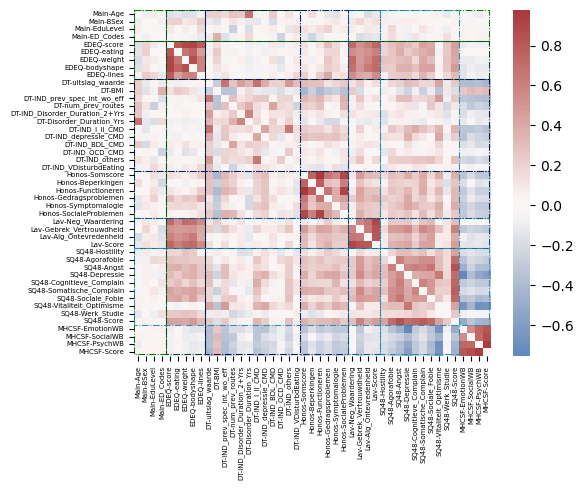

In [5]:
#df_dec_mhcsf_sq48
import matplotlib.patches as patches
#cols2consider=np.setdiff1d(cols2consider, ['EDtypes', 'bsex'])+['Edu_codes', 'ED_Codes']
cc_df_train_explore=df_train_explore[cols2consider].corr(method='spearman')
np.fill_diagonal(cc_df_train_explore.values, 0)
cc_col_dict=dict(zip(cc_df_train_explore.columns, colNames))
cc_df_train_explore.rename(columns=cc_col_dict, index=cc_col_dict, inplace=True)
fs=5
#print(df_train_explore['verstoord_eetpatroon'].value_counts())
fig0, ax0=plt.subplots(1,1,figsize=(6,5))
sns.axes_style('ticks')
#sns.set(font_scale=0.8)
sns.heatmap(cc_df_train_explore, cmap="vlag", annot=False, xticklabels=colNames, yticklabels=colNames, ax=ax0, center=0)
#ax0.set_xticks(range(0, 39, 1))
ax0.tick_params(axis='x', labelrotation=90)
ax0.tick_params(axis='y', labelrotation=0)
ax0.tick_params(left=True, bottom=True)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize = fs, ha='center')
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize = fs, va='center')
colors = plt.cycler("color", plt.cm.ocean(np.linspace(0, 1, 7+1)))
xy=[[0,0],[4,0],[5+len(colsEDEQ),0],[5+len(colsEDEQ)+len(colsDectools),0],[5+len(colsEDEQ)+len(colsDectools)+len(colsHonos),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)+len(colsMHCSF),0]]
yx=[[0,0],[0,4],[0,5+len(colsEDEQ)],[0,5+len(colsEDEQ)+len(colsDectools)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)+len(colsMHCSF)]]

width, height=[4, len(colsEDEQ)+1,len(colsDectools),len(colsHonos),len(colsLAV),len(colsSQ48),3.0], 44.75
for k, col in zip(range(0,6), colors):
    ax0.add_patch(patches.Rectangle(xy[k],width[k],height,edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
    ax0.add_patch(patches.Rectangle(yx[k],height,width[k],edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
plt.tight_layout()
plt.savefig('figs/PDFs//correlationMatrix.pdf')
plt.savefig('figs/PNGs/correlationMatrix.png')

In [6]:
n, unique_pairs = 25,[] # change this to the number of pairs you want to get
top_pairs = cc_df_train_explore.unstack().sort_values(ascending=False)[:n*2]
bottom_pairs = cc_df_train_explore.unstack().sort_values(ascending=True)[:n*2]
# Create a list to store the top pairs without duplicates
# Iterate over the top pairs and add only unique pairs to the list
for pair in top_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
top_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    top_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
unique_pairs, n=[],10
for pair in bottom_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
bottom_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    bottom_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
corr_high_lows=pd.concat([top_pairs_df, bottom_pairs_df])
# Print the top pairs as a dataframe
display(corr_high_lows)

,feature_1,feature_2,corr_coef
0,Honos-Somscore,Honos-Functioneren,0.978046
1,MHCSF-Score,MHCSF-PsychWB,0.948154
2,Honos-Functioneren,Honos-SocialeProblemen,0.914491
3,EDEQ-score,EDEQ-bodyshape,0.908334
4,Lav-Neg_Waardering,Lav-Score,0.901230
5,Honos-Somscore,Honos-SocialeProblemen,0.892236
6,EDEQ-score,EDEQ-weight,0.891374
7,MHCSF-Score,MHCSF-SocialWB,0.867165
8,EDEQ-bodyshape,EDEQ-weight,0.858348
9,SQ48-Score,SQ48-Angst,0.851712


Correlation matrix suggests the following:
- SQ48 and MHC-SF seem to have interesting negative Spearman correlation coefficients: Discuss with Pia, Joyce, Mladena
- LAV seems to be quite highly correlated with EDEQ score: Discuss if this relation to understand why this is so
- 

In [7]:
df_Questionnaires['Diff']=df_Questionnaires['leeftijd_invullen']-df_Questionnaires['age']
df_Questionnaires[['intid', 'pid', 'leeftijd_invullen', 'age', 'Diff']].loc[df_Questionnaires['Diff'].abs()>=1].head(4)

,intid,pid,leeftijd_invullen,age,Diff
2,1294,25,21,20,1
4,794,56,55,52,3
13,1411,237,23,22,1
15,1532,255,28,29,-1


### Visualizing Missing Values

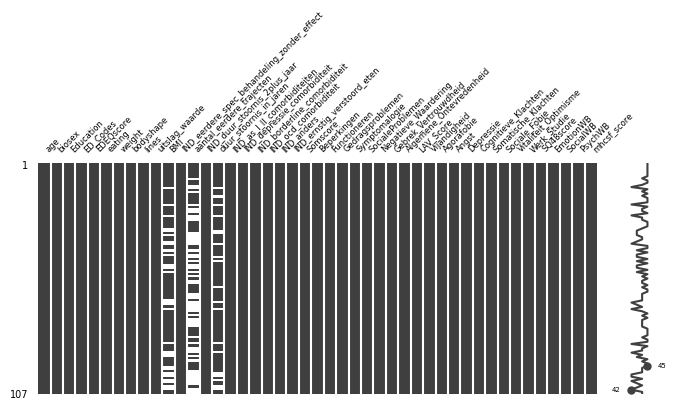

In [8]:
#!pip install missingno
import missingno as msno 
fig = msno.matrix(df_train_explore[cols2consider],figsize=(8, 3), fontsize=6)
grid_ax = fig.axes
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_NaNPatterns.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_NaNPatterns.png'%savetag)

In [9]:
df_train_explore=df_Questionnaires.loc[df_Questionnaires['Split']=='Train'].copy()
df_train_explore['bsex'] = df_train_explore['bsex'].astype('category')
df_train_explore['biosex'] = df_train_explore['bsex'].cat.codes
df_train_explore['biosex']=df_train_explore['biosex'].astype(float)
df_train_explore['EDtype'] = df_train_explore['EDtype'].astype('category')
df_train_explore['ED_Codes'] = df_train_explore['EDtype'].cat.codes
df_train_explore['Highest_Edu'] = df_train_explore['Highest_Edu'].astype('category')
df_train_explore['Education'] = df_train_explore['Highest_Edu'].cat.codes
df_train_explore['Education']=df_train_explore['Education'].astype(float)
df_train_explore['BMI']=df_train_explore['BMI'].astype(float)
df_train_explore['duur_stoornis_in_jaren']=df_train_explore['duur_stoornis_in_jaren'].astype(float)

#### Eigenvalue decomposition to PCA
#### PPCA

##### EVD of data $X$: steps:
1. Center $X$: $X_c= X-\hat{X}$
2. Covariance of $X_c$: $C=X_c^{T}X_c$ (This also ensures )
3. Eigenvalue decomposition of Covariance of $X_c$: $eigVal, eigVec=eig(C) $

In [10]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
from numpy.linalg import norm
from sklearn import metrics
cols2train=['age','biosex', 'Education']+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF
#cols2train=np.setdiff1d(cols2train,['EDEQscore','ED_Codes'])
labels_true=df_train_explore['ED_Codes']#df_Questionnaires['EDtype'].loc[df_Questionnaires['Split']=='Train']
nan_mean=np.nanmean(df_train_explore[cols2train].to_numpy(), axis=1)
nan_std=np.nanstd(df_train_explore[cols2train].to_numpy(), axis=1)
z_train_explore=((df_train_explore[cols2train].to_numpy().T-nan_mean)/nan_std).T
mask=~np.isnan(z_train_explore)
maskedarr = np.ma.array(z_train_explore, mask=~mask)
eig_val, eig_vec=np.linalg.eig(np.ma.dot(maskedarr.T, maskedarr, mask).data)
explained_var=np.cumsum(eig_val/np.sum(eig_val))
sind_eig_val=np.argsort(-1*(explained_var))
ndim=3
evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:3]].T, mask)
#!pip install ppca
from ppca import PPCA
ppca_whole = PPCA()
ppca_whole.fit(data=z_train_explore, d=38, verbose=False)
variance_explained, components, model_params  = ppca_whole.var_exp, ppca_whole.data, ppca_whole.C
variance_explained2=np.cumsum(variance_explained/np.sum(variance_explained))
components

array([[ 0.86463011, -1.47022347, -1.00202895, ..., -0.67372093,
        -0.54562565, -0.49943803],
       [ 0.08219749, -0.55265487, -0.54844847, ...,  0.54899058,
         0.99051951,  0.96298655],
       [-0.95017985,  0.84229576, -1.05669642, ..., -0.44679667,
        -0.27097844, -0.41160973],
       ...,
       [-0.64053692, -0.13383379, -0.48486699, ..., -0.38941895,
        -0.93035824, -0.78015206],
       [ 3.72299583,  4.0220631 ,  1.82561155, ...,  5.09273823,
         6.18914161,  6.13436688],
       [ 0.01052846, -0.68957468,  1.55811301, ...,  1.84585195,
         1.13994168,  0.84912861]])

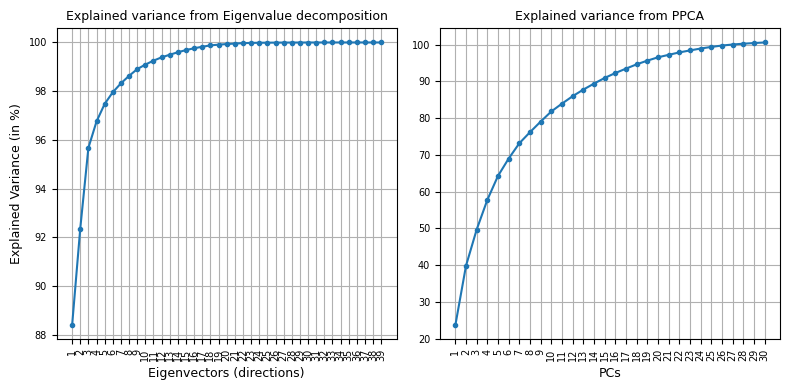

In [11]:
np.shape(eig_vec**2)
fs=9
f0,(a0, a1)=plt.subplots(1,2,figsize=(8, 4))# Create a scree plot to visualize the explained variance
a0.plot(range(1, len(explained_var) + 1), # x-axis
         explained_var*100, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a0.set_title('Explained variance from Eigenvalue decomposition', fontsize=fs)
a0.set_xlabel('Eigenvectors (directions)', fontsize=fs)
a0.set_ylabel('Explained Variance (in %)', fontsize=fs)
#plt.xtick
# Add label to x-axis
a0.set_xticks(range(1, len(explained_var) + 1))
a0.set_xticklabels(a0.get_xticklabels(), fontsize=fs-2, rotation=90)
a0.set_yticklabels(a0.get_yticklabels(), fontsize=fs-2)
# Add grid in the background
a0.grid(True)
a1.plot(range(1, len(variance_explained) + 1), # x-axis
         variance_explained*100, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a1.set_ylabel('')
a1.set_xticks(range(1, len(variance_explained) + 1))
a1.set_xticklabels(a1.get_xticklabels(), fontsize=fs-2, rotation=90)
a1.set_yticklabels(a1.get_yticklabels(), fontsize=fs-2)
a1.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_PPCA.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_EVD_PPCA.pdf'%savetag)

In [12]:
evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:3]].T, mask)
evd_pdist_cos=pairwise_distances(evd_z_train_explore, metric='cosine')
evd_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=5,
                        ).fit(-1*evd_pdist_cos)
evd_cluster_centers_indices, evd_labels = evd_af.cluster_centers_indices_, evd_af.labels_
np.fill_diagonal(evd_pdist_cos, 0)
evd_n_clusters_ = len(evd_cluster_centers_indices)
print("Estimated number of clusters: %d" % evd_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, evd_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, evd_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, evd_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, evd_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, evd_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(evd_pdist_cos, evd_labels, metric="precomputed"))
z_df_train_explore=pd.DataFrame(z_train_explore, columns=cols2train)

Estimated number of clusters: 13
Homogeneity: 0.169
Completeness: 0.107
V-measure: 0.131
Adjusted Rand Index: 0.015
Adjusted Mutual Information: 0.001
Silhouette Coefficient: 0.495


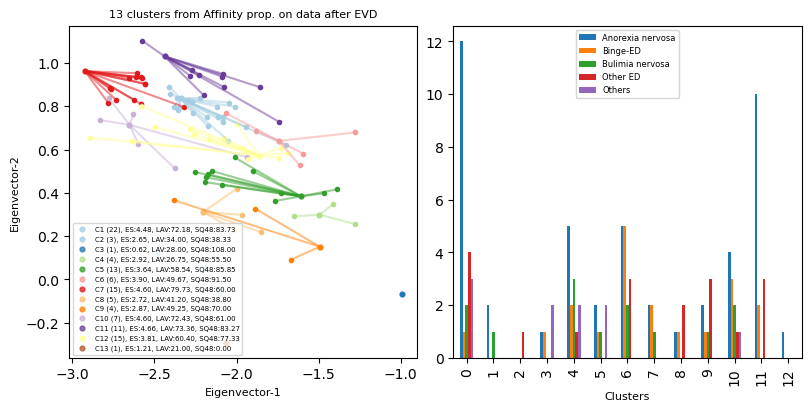

In [13]:
cluster_model={'model': evd_af, 'name': 'Affinity', 'pred_labels': evd_labels,
               'cluster_center_indices':evd_cluster_centers_indices}
data_tabs={'data_to_cluster': evd_pdist_cos, 'data_to_plot': evd_z_train_explore,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['EVD_AP_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_ed_cluster_df, ed_evd_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

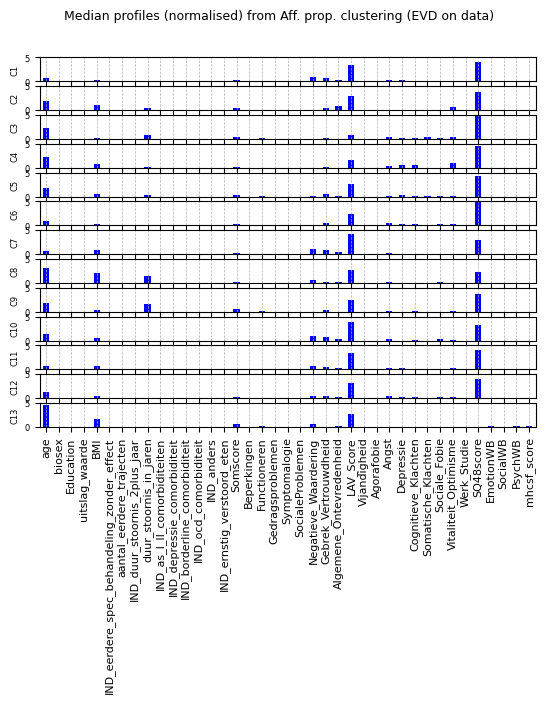

In [14]:
fig31, ax31 = plt.subplots(nrows=evd_n_clusters_, ncols=1)
#colnames=np.setdiff1d(af_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
prof_colnames=zs_evd_ed_cluster_df[cols2train].columns
for nrow in range(0,evd_n_clusters_):
    df_temp=zs_evd_ed_cluster_df[cols2train].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax31[nrow])
    ax31[nrow].set_ylim(0, 5)
    ax31[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax31[nrow].set_yticklabels(ax31[nrow].get_yticklabels(), fontsize=6)
    if nrow<evd_n_clusters_-1:        
        ax31[nrow].set_xticklabels('')
    else:
        ax31[nrow].set_xticklabels(prof_colnames, fontsize=8)    
    ax31[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig31.suptitle('Median profiles (normalised) from Aff. prop. clustering (EVD on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_AP_Profiles.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_EVD_AP_Profiles.png'%savetag)

In [15]:
ppca = PPCA()
ppca.fit(data=z_train_explore, d=3, verbose=False)
variance_explained, components, model_params  = ppca.var_exp, ppca.data, ppca.C
component_mat = ppca.transform()
ppca_pdist_cos=pairwise_distances(component_mat, metric='cosine')
ppca_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=20).fit(-1*ppca_pdist_cos)
ppca_cluster_centers_indices, ppca_labels = ppca_af.cluster_centers_indices_, ppca_af.labels_
ppca_n_clusters_ = len(ppca_cluster_centers_indices)
print("Estimated number of clusters: %d" % ppca_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, ppca_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, ppca_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, ppca_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, ppca_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, ppca_labels))
np.fill_diagonal(ppca_pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(ppca_pdist_cos, ppca_labels, metric="precomputed"))

Estimated number of clusters: 11
Homogeneity: 0.250
Completeness: 0.153
V-measure: 0.190
Adjusted Rand Index: 0.036
Adjusted Mutual Information: 0.082
Silhouette Coefficient: 0.517


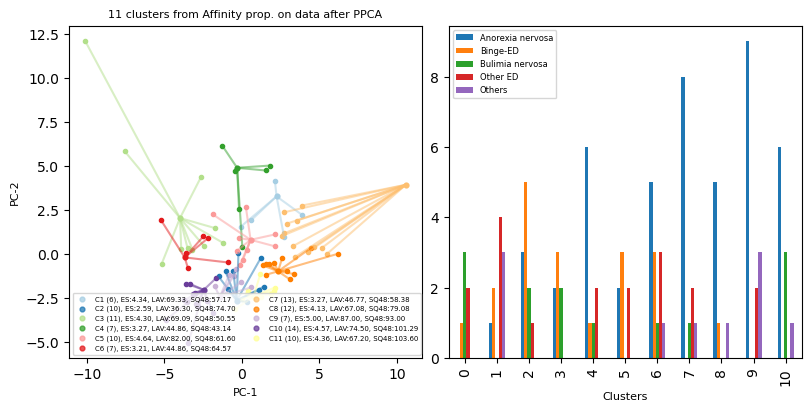

In [16]:
cluster_model={'model': ppca_af, 'name': 'Affinity', 'pred_labels': ppca_labels,
               'cluster_center_indices':ppca_cluster_centers_indices}
data_tabs={'data_to_cluster': ppca_pdist_cos, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_AP_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after PPCA', 'ncols':2,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_ed_cluster_df, ed_ppca_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

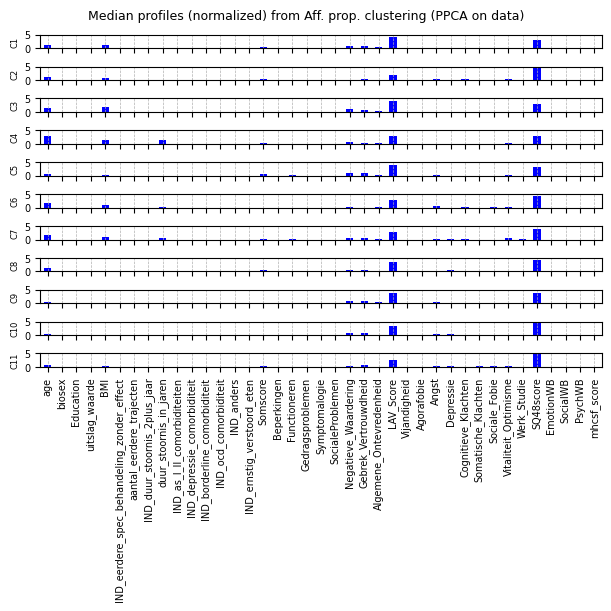

In [17]:
fig41, ax41 = plt.subplots(nrows=ppca_n_clusters_, ncols=1, layout='constrained', figsize=(6,6))
prof_colnames=zs_ppca_ed_cluster_df[cols2train].columns
for nrow in range(0,ppca_n_clusters_):
    df_temp=zs_ppca_ed_cluster_df[cols2train].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax41[nrow])
    ax41[nrow].set_ylim(0, 5)
    ax41[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax41[nrow].set_yticklabels(ax41[nrow].get_yticklabels(), fontsize=fs-2)
    if nrow<ppca_n_clusters_-1:        
        ax41[nrow].set_xticklabels('')
    else:
        ax41[nrow].set_xticklabels(prof_colnames, fontsize=fs-2)    
    ax41[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig41.suptitle('Median profiles (normalized) from Aff. prop. clustering (PPCA on data)', fontsize=fs)
plt.savefig('figs/PDFs/ED_c%s_PPCA_AP_Profiles.pdf'%savetag)
plt.savefig('figs/PNGs/ED_c%s_PPCA_AP_Profiles.png'%savetag)

#### Trying Affinity Propagation without any dimensionality reduction (i.e., without EVD or PPCA)

In [18]:
pdist_cos = np.zeros((np.shape(z_train_explore)[0],np.shape(z_train_explore)[0]))
for i in range(np.shape(z_train_explore)[0]):
    for j in range(np.shape(z_train_explore)[0]):
        combo_mask=mask[i]& mask[j]
        temp_i, temp_j=z_train_explore[i], z_train_explore[j]
        c_tmp = np.dot(temp_i[combo_mask], temp_j[combo_mask])/(norm(temp_i[combo_mask])*norm(temp_j[combo_mask])) 
        pdist_cos[i][j] = c_tmp
af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=500, convergence_iter=20).fit(-1*pdist_cos)
cluster_centers_indices, labels, n_clusters_ = af.cluster_centers_indices_, af.labels_, len(af.cluster_centers_indices_)
print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, labels))
np.fill_diagonal(pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pdist_cos, labels, metric="precomputed"))

Estimated number of clusters: 2
Homogeneity: 0.029
Completeness: 0.173
V-measure: 0.049
Adjusted Rand Index: 0.032
Adjusted Mutual Information: 0.024
Silhouette Coefficient: -0.115


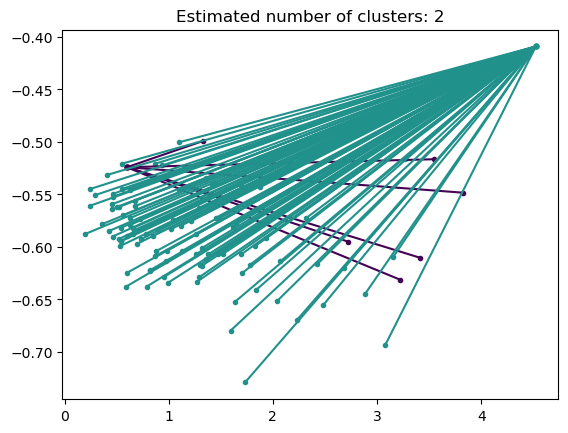

In [19]:
plt.figure(0)
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_+1)))
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = z_train_explore[cluster_centers_indices[k]]
    cluster_center=cluster_center[mask[cluster_centers_indices[k]]]
    plt.scatter(z_train_explore[class_members, 0], z_train_explore[class_members, 1], 
                color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in z_train_explore[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

#### Clustering with Gaussian Mixture models

In [20]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

,Number of components,Type of covariance,Init params,BIC score
63,3,spherical,k-means++,37.657858
54,3,spherical,kmeans,37.813528
72,3,spherical,random_from_data,38.086496
64,4,spherical,k-means++,55.847515
55,4,spherical,kmeans,56.808076


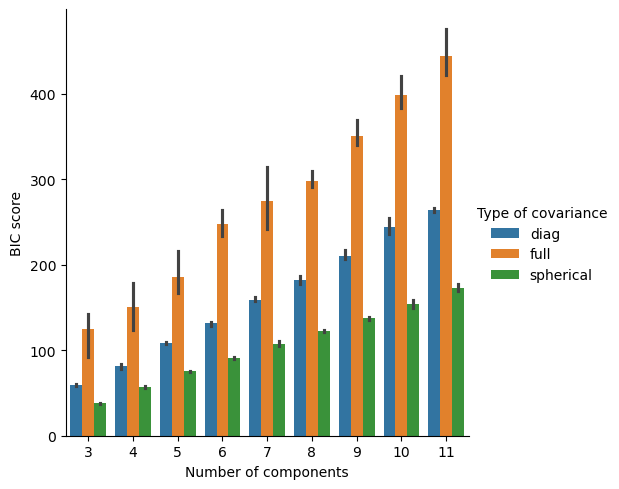

In [21]:
param_grid = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
grid_search = GridSearchCV(GaussianMixture(n_init=20, max_iter=300), param_grid=param_grid, scoring=gmm_bic_score)
grid_search.fit(evd_z_train_explore.data)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
sns.catplot(data=df, kind="bar", x="Number of components", y="BIC score", hue="Type of covariance",)
#plt.show()
df.sort_values(by=["BIC score"]).head()

In [22]:
#evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:3]].T, mask)
iters, n_components, data_to_cluster=5, 3, evd_z_train_explore.data
sill=np.zeros(iters,)
for iter in range(0,iters):
    gmm_model_try=GaussianMixture(n_init=20, max_iter=100, n_components=n_components, covariance_type='spherical', 
                          init_params='k-means++').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, gmm_model_try.predict(data_to_cluster), metric="euclidean")
    
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
evd_gmm_model=GaussianMixture(n_init=20, max_iter=100, n_components=n_components, covariance_type='spherical', 
                          init_params='k-means++', random_state=11).fit(data_to_cluster)
evd_gmm_labels=evd_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"%(metrics.silhouette_score(data_to_cluster, evd_gmm_labels, metric="euclidean")) )
evd_gmm_ED_cluster=df_train_explore[['EDtype', 'EDEQscore']].copy()
evd_gmm_ED_cluster['GMMcluster']=evd_gmm_labels

Average silhouette Coefficient: 0.311 (0.004)
Silhouette Coefficient: 0.306


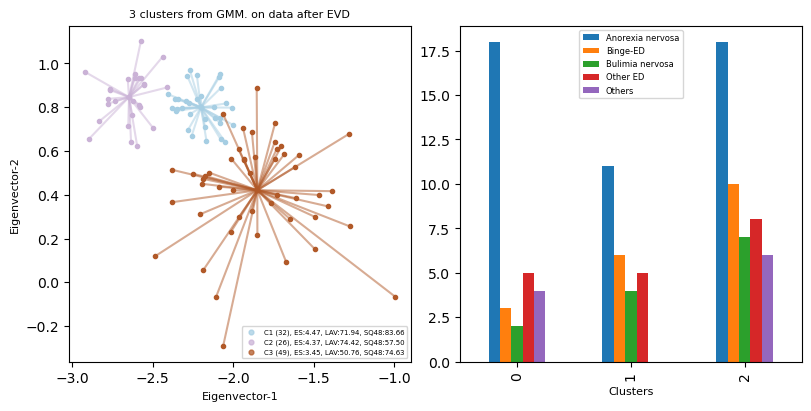

In [23]:
cluster_model={'model': evd_gmm_model, 'name': 'GMM', 'pred_labels': evd_gmm_labels}
data_tabs={'data_to_cluster':evd_z_train_explore.data, 'data_to_plot': evd_z_train_explore.data,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['EVD_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower right', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_gmm_ed_cluster_df, ed_evd_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

#### Prepresentative profiles of each cluster

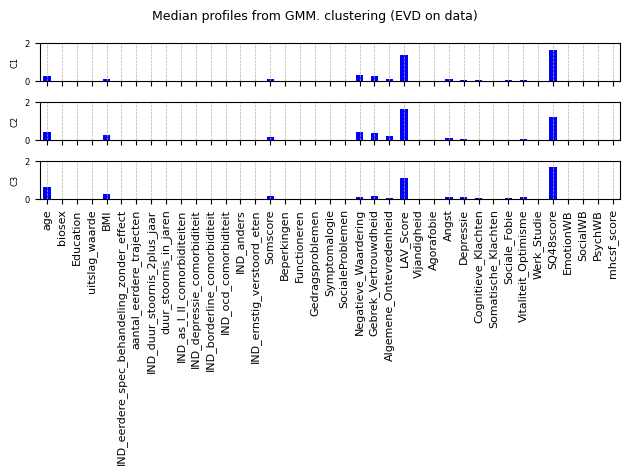

In [24]:
fig51, ax51 = plt.subplots(nrows=n_components, ncols=1)
colnames=zs_evd_gmm_ed_cluster_df.columns#np.setdiff1d(gmm_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,n_components):
    df_temp=zs_evd_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax51[nrow])
    ax51[nrow].set_ylim(0, 5)
    ax51[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax51[nrow].set_yticklabels(ax51[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax51[nrow].set_xticklabels('')
    else:
        ax51[nrow].set_xticklabels(colnames, fontsize=8)    
    ax51[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig51.suptitle('Median profiles from GMM. clustering (EVD on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/ED_%s_EVD_GMM_Profiles.pdf'%savetag)
plt.savefig('figs/ED_%s_EVD_GMM_Profiles.png'%savetag)

In [69]:
param_grid2 = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
grid_search2 = GridSearchCV(GaussianMixture(n_init=3, max_iter=300), param_grid=param_grid2, scoring=gmm_bic_score)
grid_search2.fit(component_mat)
df2 = pd.DataFrame(grid_search2.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df2["mean_test_score"] = -df2["mean_test_score"]
df2 = df2.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df2.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
63,3,spherical,k-means++,338.728758
72,3,spherical,random_from_data,339.498298
54,3,spherical,kmeans,343.868679
73,4,spherical,random_from_data,356.250160
64,4,spherical,k-means++,358.919897


In [25]:
n_components, data_to_cluster=3, component_mat
sill=np.zeros(iters,)
for iter in range(0,iters):
    ppca_gmm_model_try=GaussianMixture(n_init=5, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='k-means++').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, ppca_gmm_model_try.predict(data_to_cluster), metric="cosine")
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
ppca_gmm_model=GaussianMixture(n_init=5, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='k-means++', random_state=11).fit(data_to_cluster)
ppca_gmm_labels=ppca_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, ppca_gmm_labels, metric="cosine"))
ppca_gmm_ED_cluster=df_train_explore[['EDtype', 'EDEQscore']].copy()
ppca_gmm_ED_cluster['GMMcluster']=ppca_gmm_labels

Average silhouette Coefficient: 0.327 (0.062)
Silhouette Coefficient: 0.322


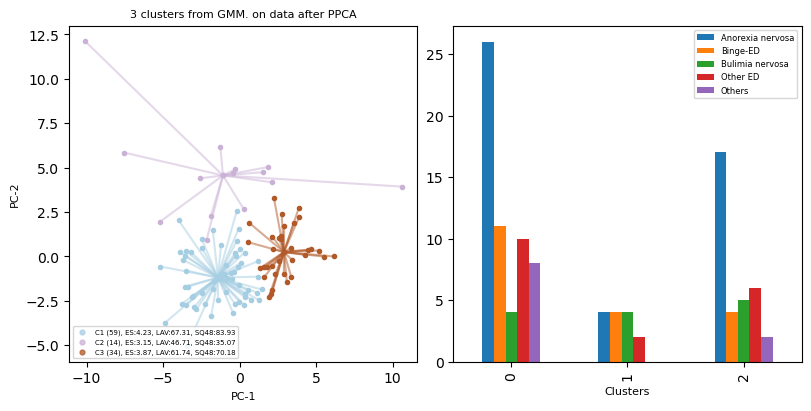

In [26]:
cluster_model={'model': ppca_gmm_model, 'name': 'GMM', 'pred_labels': ppca_gmm_labels}
data_tabs={'data_to_cluster':component_mat, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after PPCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_gmm_ed_cluster_df, ed_ppca_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

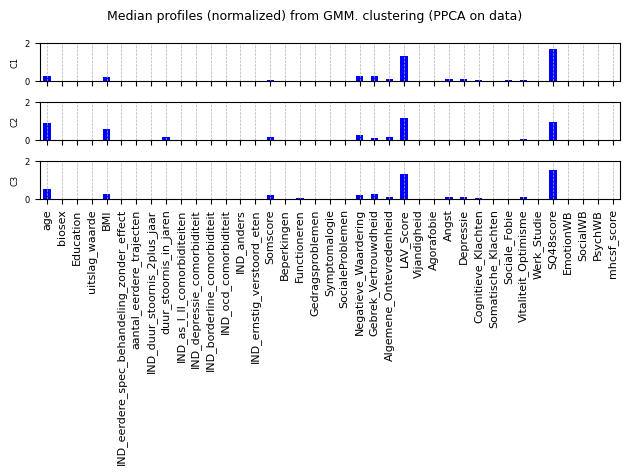

In [27]:
fig61, ax61 = plt.subplots(nrows=n_components, ncols=1)
colnames=zs_ppca_gmm_ed_cluster_df.columns
for nrow in range(0,n_components):
    df_temp=zs_ppca_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax61[nrow])
    ax61[nrow].set_ylim(0, 5)
    ax61[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax61[nrow].set_yticklabels(ax61[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax61[nrow].set_xticklabels('')
    else:
        ax61[nrow].set_xticklabels(colnames, fontsize=8)    
    ax61[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig61.suptitle('Median profiles (normalized) from GMM. clustering (PPCA on data)', fontsize=9)
plt.tight_layout()
savetag='combinedDatasets'
plt.savefig('figs/ED_%s_PPCA_GMM_Profiles.pdf'%(savetag))

#### Agglomerative clustering

In [28]:
from sklearn.cluster import AgglomerativeClustering
data_to_cluster, linkage, diss=ppca_pdist_cos, 'complete', 'precomputed'
sill_coef=np.zeros((5,11))
for idx,n_comp in enumerate(range(2,13)):
    for iter in range(0,5):
        try_agg_clust=AgglomerativeClustering(n_clusters=n_comp, affinity=diss, linkage=linkage).fit(data_to_cluster)
        sill_coef[iter, idx]=metrics.silhouette_score(data_to_cluster,try_agg_clust.fit_predict(data_to_cluster), metric=diss)
    print("Silhouette Coefficient of %d clusters: %0.3f (%0.3f)"%(n_comp, np.mean(sill_coef[:,idx]), np.std(sill_coef[:,idx])))

ncomp=np.argsort(-1*np.mean(sill_coef,axis=0))[0]+2
agg_clust=AgglomerativeClustering(n_clusters=ncomp, affinity=diss, linkage=linkage).fit(data_to_cluster)
agg_labels=agg_clust.fit_predict(data_to_cluster)

Silhouette Coefficient of 2 clusters: 0.427 (0.000)
Silhouette Coefficient of 3 clusters: 0.415 (0.000)
Silhouette Coefficient of 4 clusters: 0.437 (0.000)
Silhouette Coefficient of 5 clusters: 0.478 (0.000)
Silhouette Coefficient of 6 clusters: 0.473 (0.000)
Silhouette Coefficient of 7 clusters: 0.481 (0.000)
Silhouette Coefficient of 8 clusters: 0.488 (0.000)
Silhouette Coefficient of 9 clusters: 0.507 (0.000)
Silhouette Coefficient of 10 clusters: 0.502 (0.000)
Silhouette Coefficient of 11 clusters: 0.507 (0.000)
Silhouette Coefficient of 12 clusters: 0.513 (0.000)


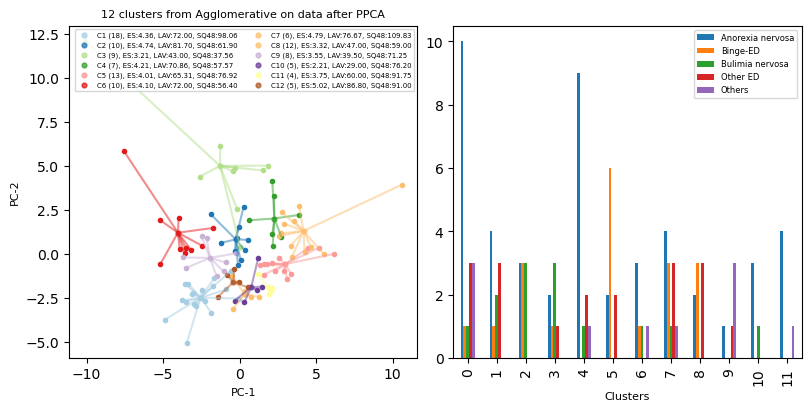

In [31]:
cluster_model={'model': agg_clust, 'name': 'Agglomerative', 'pred_labels':agg_labels}
data_tabs={'data_to_cluster':ppca_pdist_cos, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_Agglom_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Agglomerative on data after PPCA', 'ncols':2,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_agg_ed_cluster_df, ed_ppca_agg_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

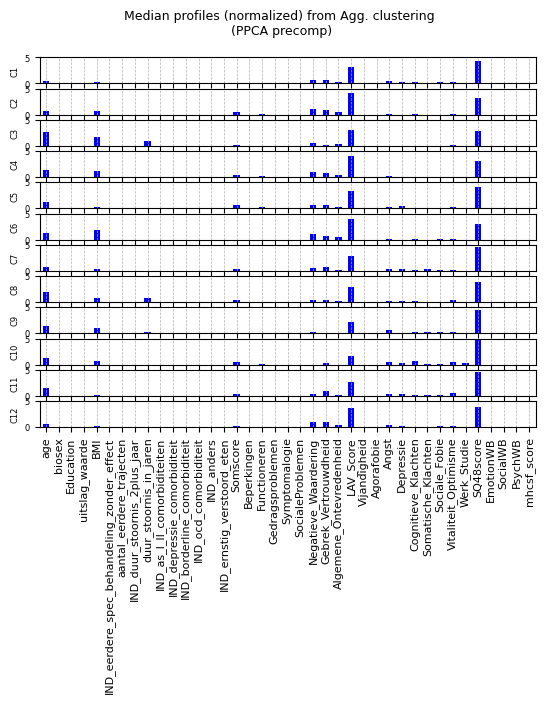

In [32]:
fig8, axes8 = plt.subplots(nrows=ncomp, ncols=1)
colnames=zs_ppca_agg_ed_cluster_df.columns
for nrow in range(0,ncomp):
    df_temp=zs_ppca_agg_ed_cluster_df.iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=axes8[nrow])
    axes8[nrow].set_ylim(0, 5)
    axes8[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    axes8[nrow].set_yticklabels(axes8[nrow].get_yticklabels(), fontsize=6)
    if nrow<ncomp-1:        
        axes8[nrow].set_xticklabels('')
    else:
        axes8[nrow].set_xticklabels(colnames, fontsize=8)    
    axes8[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig8.suptitle('Median profiles (normalized) from Agg. clustering\n (PPCA precomp)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/ED_combinedDatasets_PPCA_Agg_Clust_Profiles.pdf')
plt.savefig('figs/ED_combinedDatasets_PPCA_Agg_Clust_Profiles.png')
    #agg_cluster_df[np.setdiff1d(agg_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])].loc[
    #agg_cluster_df['Cluster']==nrow+1].plot(ax=axes8[nrow], kind='bar')